# Project by: **Krishana Choudhary**

 
**Instructor:** Dr. Abhishek Saini  
**Program:** Ph.D.  
**Roll Number:** D24170   
**Date:** 30 June 2025  


---

## 📚 References

1. Problem is taken out from deepxde website: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/eulerbeam.html
2. **ChatGPT (OpenAI):** Assisted with conceptual clarification, coding structure, debugging.  

---


# Euler Beam
## Problem setup
We will solve a Euler beam problem:
$${\frac{d^4 u}{dx^4} + 1 = 0} ,  \qquad      x \in [0, 1]$$
with two boundary conditions on the right boundary, 
$${u''(1)=0, u'''(1) = 0}$$
and one Dirichlet boundary condition on the left boundary,
$$ u(0)=0 $$
along with one Neumann boundary condition on the left boundary,
$$ u'(0) = 0 $$
The exact solution is 
$$ u(x) = -(1/24 )x^4 + (1/6 )x^3 -(1/4 )x^2 .$$

#  Workflow Summary: Solving the Euler Beam Problem using PINNs

##  Step 1: Problem Statement
 We solve the fourth-order ODE:
     d⁴u/dx⁴ + 1 = 0  over the domain x ∈ [0, 1]

### Boundary Conditions:
 - u(0) = 0                  (Dirichlet at x=0)
 - u'(0) = 0                 (Neumann at x=0)
 - u''(1) = 0, u'''(1) = 0   (Natural BCs at x=1)

 The exact solution is:
     u(x) = -(1/24)x⁴ + (1/6)x³ - (1/4)x²

##  Step 2: Define Neural Network Model
 A fully connected feedforward network is built with:
 - Input: x
 - Output: u(x)
 - 4 hidden layers of 20 neurons each with Tanh activation

##  Step 3: Define PDE Residual
 Using automatic differentiation (torch.autograd), we compute:
     d⁴u/dx⁴ + 1
 The squared residual forms the PDE loss.

##  Step 4: Enforce Boundary Conditions
 Compute losses for:
 - u(0) = 0
 - u'(0) = 0
 - u''(1) = 0
 - u'''(1) = 0
### These are added as MSE losses using autograd.

##  Step 5: Training Loop
 - Sample 100 points from the domain x ∈ [0, 1]
 - Total Loss = PDE loss + Boundary loss
 - Optimizer: Adam
 - Train for 5000 epochs, printing loss every 500 epochs

##  Step 6: Post-Processing
 - Generate 200 test points in the domain
 - Predict u(x) using trained model
 - Compute exact u(x) for comparison
 - Plot predicted vs exact solution

##  Output: The PINN learns to approximate the beam deflection accurately


In [8]:
#############################################################################################
# Physics-Informed Neural Network (PINN)
# Euler Beam Bending Problem
############################################################################################################

# Importing necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Device configuration (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} ({torch.cuda.get_device_name(0) if device.type == 'cuda' else 'CPU'})")

#######################################################
# Define the PINN model with 1 input (x) and 1 output (u)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        #  Define the neural network layers using nn.Sequential
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),   # Input layer: 1 neuron (x) → 20 hidden neurons
            nn.Tanh(),          # Activation function: Tanh
            nn.Linear(20, 20),  # Hidden layer: 20 → 20
            nn.Tanh(),
            nn.Linear(20, 20),  # Hidden layer: 20 → 20
            nn.Tanh(),
            nn.Linear(20, 20),  # Hidden layer: 20 → 20
            nn.Tanh(),
            nn.Linear(20, 1)    # Output layer: 20 → 1 neuron (u(x))
        )

    def forward(self, x):
        """
         Forward pass: Computes the network output u(x)
        Input:
            x : tensor of shape [N, 1], spatial coordinate
        Output:
            u(x) : tensor of shape [N, 1], predicted displacement
        """
        return self.hidden(x)
########################################################

##############################################################################
#  PDE Residual Function: Implements the Euler beam equation d⁴u/dx⁴ + 1 = 0
def pde(x, model):
    #  Enable gradient tracking for x so we can compute derivatives
    x.requires_grad = True

    #  Predict displacement u(x) using the model
    u = model(x)

    # Compute successive derivatives using automatic differentiation
    du_dx     = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]     # First derivative: u'
    d2u_dx2   = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]  # Second derivative: u''
    d3u_dx3   = torch.autograd.grad(d2u_dx2, x, grad_outputs=torch.ones_like(d2u_dx2), create_graph=True)[0]  # Third derivative: u'''
    d4u_dx4   = torch.autograd.grad(d3u_dx3, x, grad_outputs=torch.ones_like(d3u_dx3), create_graph=True)[0]  # Fourth derivative: u⁽⁴⁾

    # Return the PDE residual: d⁴u/dx⁴ + 1 (should ideally be ≈ 0)
    return d4u_dx4 + 1
##############################################################################


##############################################################################
#  Boundary Condition Loss Function for the Euler Beam Problem
def bc_loss(model):
    #  Define boundary points at x = 0 and x = 1
    x0 = torch.tensor([[0.0]], requires_grad=True).to(device)  # Left boundary
    x1 = torch.tensor([[1.0]], requires_grad=True).to(device)  # Right boundary

    #  Dirichlet BC at x = 0: u(0) = 0
    u0 = model(x0)

    #  Neumann BC at x = 0: u'(0) = 0
    du0 = torch.autograd.grad(u0, x0, torch.ones_like(u0), create_graph=True)[0]

    #  Higher-order natural BCs at x = 1
    u1 = model(x1)
    du1 = torch.autograd.grad(u1, x1, torch.ones_like(u1), create_graph=True)[0]         # u'(1)
    d2u1 = torch.autograd.grad(du1, x1, torch.ones_like(du1), create_graph=True)[0]      # u''(1) = 0
    d3u1 = torch.autograd.grad(d2u1, x1, torch.ones_like(d2u1), create_graph=True)[0]    # u'''(1) = 0

    #  Compute mean squared error for all boundary conditions
    return u0.pow(2).mean() + du0.pow(2).mean() + d2u1.pow(2).mean() + d3u1.pow(2).mean()
##############################################################################



##############################################################################
#  Model and Optimizer Setup
model = PINN().to(device)                                # Instantiate the neural network and move it to device (CPU/GPU)
optimizer = optim.Adam(model.parameters(), lr=1e-3)      # Use Adam optimizer with learning rate 0.001

#  Sample collocation points (interior points) in the domain [0, 1]
x_interior = torch.linspace(0, 1, 100).view(-1, 1).to(device)
x_interior.requires_grad = True                          # Enable gradients for automatic differentiation

#  Training loop
epochs = 5000
for epoch in range(epochs+1):
    optimizer.zero_grad()                                # Clear previous gradients
    model.train()                                        # Set model to training mode

    #  Compute losses
    f = pde(x_interior, model)                           # Compute PDE residuals at interior points
    loss_pde = (f ** 2).mean()                           # Mean squared PDE residual loss
    loss_bcs = bc_loss(model)                            # Compute boundary condition loss
    loss = loss_pde + loss_bcs                           # Total loss (physics + BCs)

    #  Backpropagation and optimization step
    loss.backward()                                      # Compute gradients
    optimizer.step()                                     # Update network weights

    #  printing training progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}, PDE Loss: {loss_pde.item():.6f}, BC Loss: {loss_bcs.item():.6f}")
##############################################################################


Using device: cpu (CPU)
Epoch 0, Total Loss: 0.910299, PDE Loss: 0.902085, BC Loss: 0.008214
Epoch 500, Total Loss: 0.003570, PDE Loss: 0.002455, BC Loss: 0.001115
Epoch 1000, Total Loss: 0.000043, PDE Loss: 0.000042, BC Loss: 0.000000
Epoch 1500, Total Loss: 0.000027, PDE Loss: 0.000027, BC Loss: 0.000000
Epoch 2000, Total Loss: 0.000021, PDE Loss: 0.000021, BC Loss: 0.000000
Epoch 2500, Total Loss: 0.000017, PDE Loss: 0.000017, BC Loss: 0.000000
Epoch 3000, Total Loss: 0.000014, PDE Loss: 0.000014, BC Loss: 0.000000
Epoch 3500, Total Loss: 0.000018, PDE Loss: 0.000017, BC Loss: 0.000001
Epoch 4000, Total Loss: 0.000010, PDE Loss: 0.000010, BC Loss: 0.000000
Epoch 4500, Total Loss: 0.000008, PDE Loss: 0.000008, BC Loss: 0.000000
Epoch 5000, Total Loss: 0.000023, PDE Loss: 0.000021, BC Loss: 0.000002


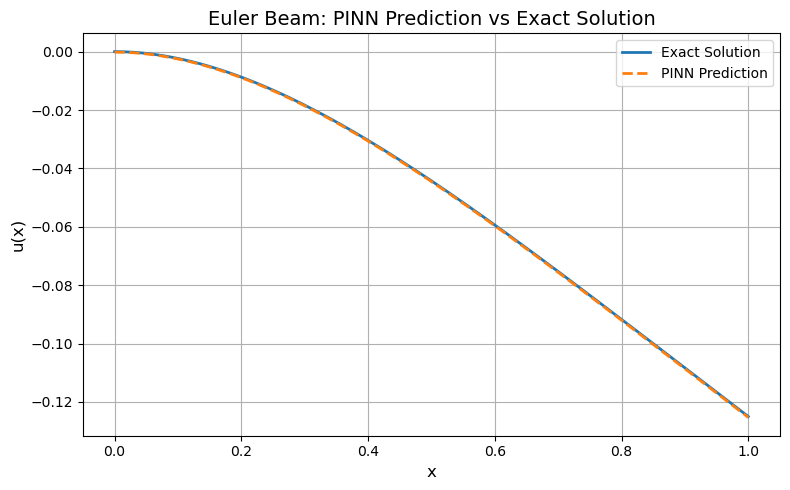

In [9]:
##############################################
# Plotting: PINN Prediction vs Exact Solution
###################################################

# Define the exact analytical solution of the Euler beam problem
def u_exact(x):
    return -(1/24)*x**4 + (1/6)*x**3 - (1/4)*x**2

# Generate evenly spaced test points in the domain [0, 1]
x_test = torch.linspace(0, 1, 200).view(-1, 1).to(device)

# Use the trained model to predict displacement u(x) at test points
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    u_pred = model(x_test).cpu().numpy()  # Detach and move to CPU for plotting

# Evaluate the exact solution on the same test points
x_np = x_test.cpu().numpy()
u_true = u_exact(x_np)

# Plot predicted vs exact displacement
plt.figure(figsize=(8, 5))
plt.plot(x_np, u_true, label='Exact Solution', linewidth=2)
plt.plot(x_np, u_pred, '--', label='PINN Prediction', linewidth=2)

# Plot styling and labels
plt.xlabel("x", fontsize=12)
plt.ylabel("u(x)", fontsize=12)
plt.title("Euler Beam: PINN Prediction vs Exact Solution", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

